# Flux of Mn across boundaries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
import seaborn as sns; sns.set()
import os
import cmocean
import pandas as pd
from calendar import monthrange
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model result set:
folder_ref      = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_cleanice = '/data/brogalla/run_storage/Mn-clean-ice-202110/'
folder_spm      = '/data/brogalla/run_storage/Mn-spm-202110/'

# Colors:
dirty  = '#90a1b1'
clean  = '#cee7fd'
rivers = '#519e98'
colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019]

###### Load files:

In [4]:
mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons      = np.array(mesh.variables['nav_lon'])
lats      = np.array(mesh.variables['nav_lat'])
depths    = np.array(mesh.variables['gdept_1d'])[0,:]

e1t_base  = np.array(mesh.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base  = np.array(mesh.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t       = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

e1t       = np.tile(e1t_base, (50,1,1))
e2t       = np.tile(e2t_base, (50,1,1))
volume    = e1t*e2t*e3t
area_base = e1t_base*e2t_base
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask[0,:,:] < 0.1), area_base)

##### Functions:

In [5]:
def time_series_pickle(year, nosed=False, rivers=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes:
    if nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-clean-ice-202110/time-series-{year}.pickle','rb'))  
    elif rivers:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-spm-202110/time-series-{year}.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(f'{folder}Mn-reference-202110/time-series-{year}.pickle','rb'))
    
    return time_series_mn2, time_series_mn11

In [6]:
def check_volume_conservation(year, nosed=False, rivers=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes Volume (m3/s) and Mn (m3/s * mol/L):
    # --> Mn is in mol/s * m3/L (* 1000 L/m3) need to multiply by 1000 to get mol / s
    if nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-clean-ice-202110/time-series-{year}.pickle','rb'))  
    elif rivers:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-spm-202110/time-series-{year}.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(f'{folder}Mn-reference-202110/time-series-{year}.pickle','rb'))
    
    return time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6, \
            time_series_V7, time_series_V8, time_series_V9, time_series_V10, time_series_V11

In [7]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(f'{folder_ref}ANHA12_ref-{year}_20211012/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

#### Calculations:

In [8]:
ref_in    = np.empty((len(years),72,50,79)); ref_out   = np.empty((len(years),72,50,52)); # ref
nosed_in  = np.empty((len(years),72,50,79)); nosed_out = np.empty((len(years),72,50,52)); # nosed
spm_in    = np.empty((len(years),72,50,79)); spm_out   = np.empty((len(years),72,50,52)); # rivers

for i, year in enumerate(years):
    ref_in1, ref_out1     = time_series_pickle(year)
    nosed_in2, nosed_out2 = time_series_pickle(year, nosed=True)
    spm_in3, spm_out3     = time_series_pickle(year, rivers=True)
    
    ref_in[i,:,:,:]    = ref_in1*1e3 # convert from mol m3/ L s --> mol / s
    nosed_in[i,:,:,:]  = nosed_in2*1e3
    spm_in[i,:,:,:]    = spm_in3*1e3
    ref_out[i,:,:,:]   = ref_out1*1e3
    nosed_out[i,:,:,:] = nosed_out2*1e3
    spm_out[i,:,:,:]   = spm_out3*1e3

In [9]:
dates = np.array([])
for year in range(2002, 2020):
    dates = np.append(dates, file_dates(year))

In [10]:
print(ref_in.shape) # year, 5 day, depth, grid points --- Mn is in mol/s for each grid point

(18, 72, 50, 79)


In [11]:
Parry_ref_cumsumin  = np.cumsum(np.sum(-1*ref_in, axis=(2,3)).flatten())
Parry_ref_cumsumout = np.cumsum(np.sum(-1*ref_out, axis=(2,3)).flatten())

Parry_ref_in  = np.sum(-1*ref_in, axis=(2,3)).flatten()
Parry_ref_out = np.sum(-1*ref_out, axis=(2,3)).flatten()

Parry_ref_diff = Parry_ref_out - Parry_ref_in

In [12]:
Parry_nosed_cumsumin  = np.cumsum(np.sum(-1*nosed_in, axis=(2,3)).flatten())
Parry_nosed_cumsumout = np.cumsum(np.sum(-1*nosed_out, axis=(2,3)).flatten())

Parry_nosed_in  = np.sum(-1*nosed_in, axis=(2,3)).flatten()
Parry_nosed_out = np.sum(-1*nosed_out, axis=(2,3)).flatten()

Parry_nosed_diff = Parry_nosed_out - Parry_nosed_in

In [13]:
Parry_rivers_cumsumin  = np.cumsum(np.sum(-1*(spm_in), axis=(2,3)).flatten())
Parry_rivers_cumsumout = np.cumsum(np.sum(-1*(spm_out), axis=(2,3)).flatten())

Parry_rivers_in  = np.sum(-1*(spm_in), axis=(2,3)).flatten()
Parry_rivers_out = np.sum(-1*(spm_out), axis=(2,3)).flatten()

Parry_rivers_diff = Parry_rivers_out - Parry_rivers_in

### Figures

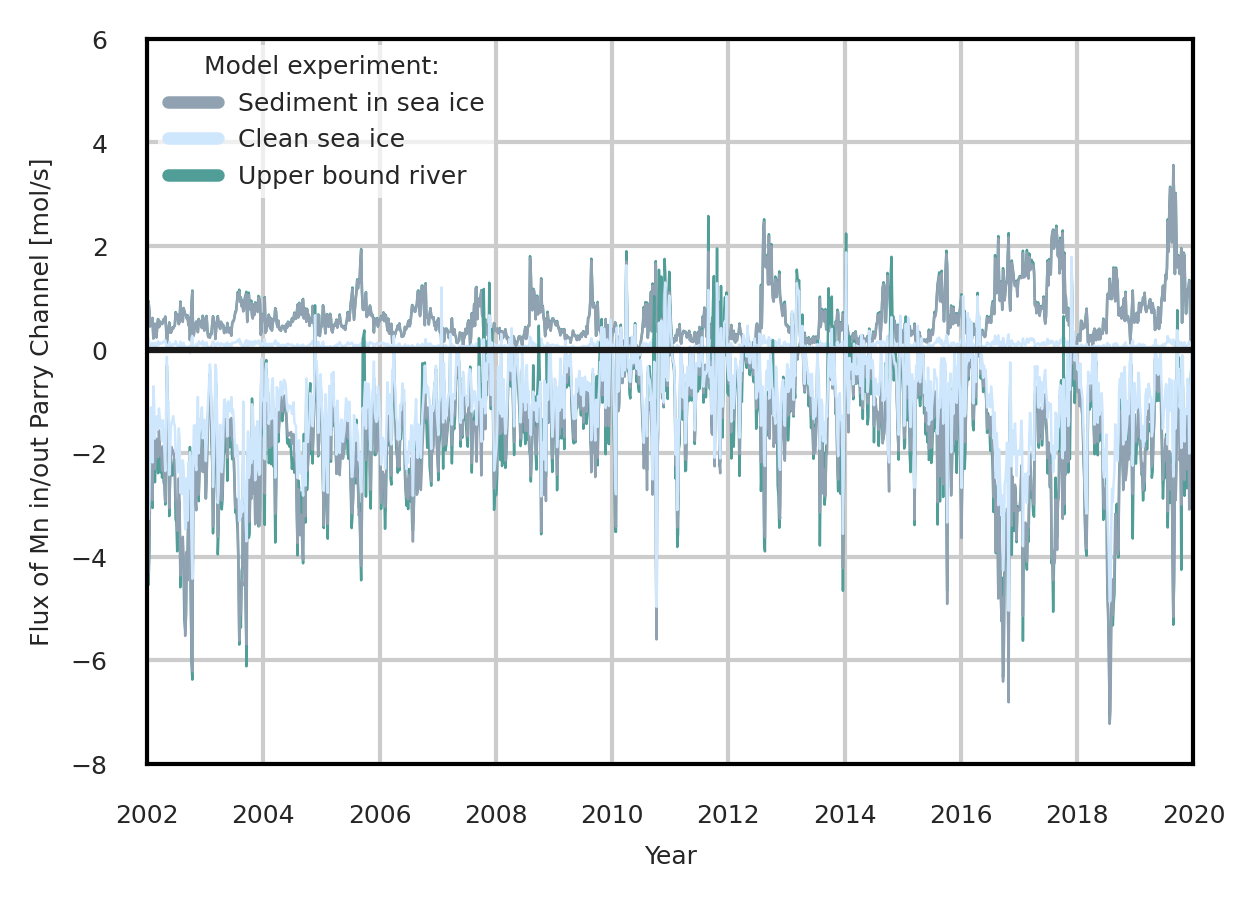

In [21]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_rivers_in,    linewidth=0.6, color=rivers, markersize=7)
    sns.lineplot(dates,      Parry_ref_in,       linewidth=0.6, color=dirty)
    sns.lineplot(dates,      Parry_nosed_in,     linewidth=0.6, color=clean, markersize=7)
    sns.lineplot(dates,      -1*Parry_rivers_out,linewidth=0.6, color=rivers)
    sns.lineplot(dates,      -1*Parry_ref_out,   linewidth=0.6, color=dirty)
    sns.lineplot(dates,      -1*Parry_nosed_out, linewidth=0.6, color=clean)
    
    sns.lineplot(dates[0],[0], linewidth=3, color=dirty, label=r'Sediment in sea ice')
    sns.lineplot(dates[0],[0], linewidth=3, color=clean, label=r'Clean sea ice')
    sns.lineplot(dates[0],[0], linewidth=3, color=rivers, label=r'Upper bound river')

    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], c='k')
    
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Flux of Mn in/out Parry Channel [mol/s]',fontsize=6)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-8,6))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.01, 0.78), frameon=True, framealpha=0.7, fontsize=6)
    leg.get_frame().set_linewidth(0.0)
    leg.set_title('Model experiment: ',prop={'size':6})
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.png', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.svg', bbox_inches='tight', dpi=300, \
            format='svg')

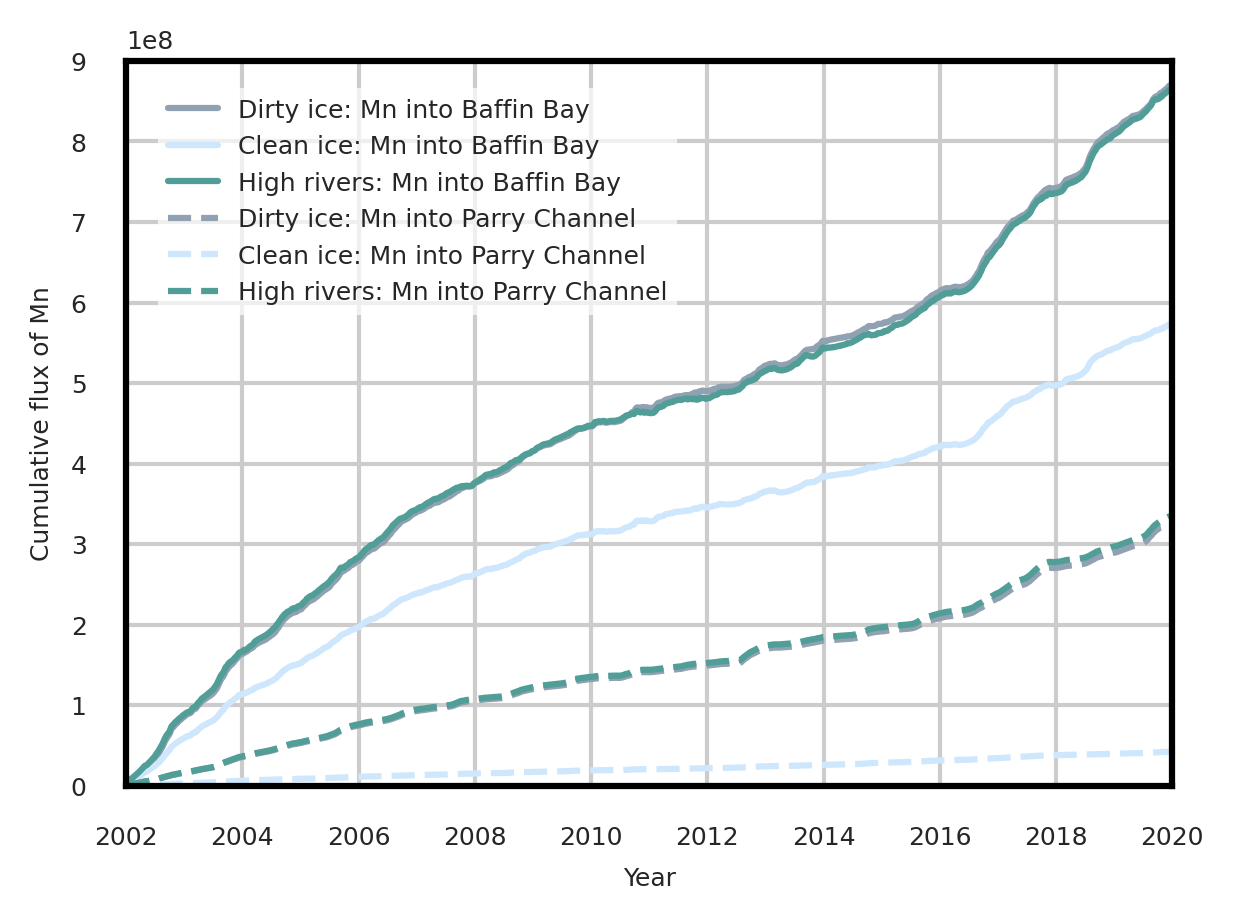

In [15]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumout*3600*24*5, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Baffin Bay')
    sns.lineplot(dates, Parry_nosed_cumsumout*3600*24*5, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Baffin Bay')
    sns.lineplot(dates, Parry_rivers_cumsumout*3600*24*5, linewidth=1.5, color=rivers, \
                 label=r'High rivers: Mn into Baffin Bay')
    sns.lineplot(dates, Parry_ref_cumsumin*3600*24*5, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_nosed_cumsumin*3600*24*5, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_rivers_cumsumin*3600*24*5, linewidth=1.5, color=rivers, \
                 label=r'High rivers: Mn into Parry Channel')
    ax.lines[3].set_linestyle('--')
    ax.lines[4].set_linestyle('--')
    ax.lines[5].set_linestyle('--')
    
    
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=6)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 9e8))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.yaxis.get_offset_text().set_fontsize(6)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.65), frameon=True, framealpha=0.7, fontsize=6)
    leg.get_frame().set_linewidth(0.0)

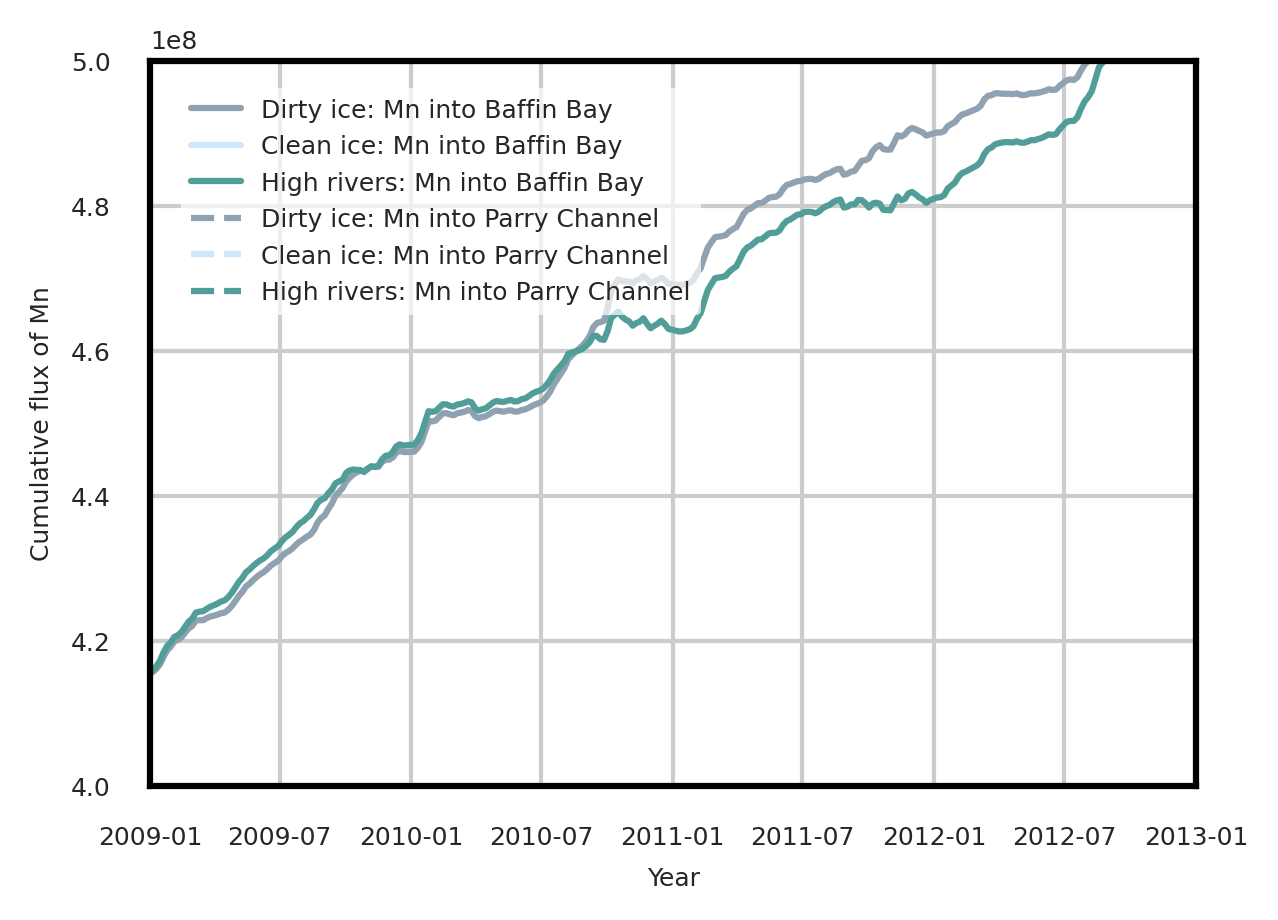

In [16]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumout*3600*24*5, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Baffin Bay')
    sns.lineplot(dates, Parry_nosed_cumsumout*3600*24*5, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Baffin Bay')
    sns.lineplot(dates, Parry_rivers_cumsumout*3600*24*5, linewidth=1.5, color=rivers, \
                 label=r'High rivers: Mn into Baffin Bay')
    sns.lineplot(dates, Parry_ref_cumsumin*3600*24*5, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_nosed_cumsumin*3600*24*5, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_rivers_cumsumin*3600*24*5, linewidth=1.5, color=rivers, \
                 label=r'High rivers: Mn into Parry Channel')
    ax.lines[3].set_linestyle('--')
    ax.lines[4].set_linestyle('--')
    ax.lines[5].set_linestyle('--')
    
    
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=6)
    ax.set(xlim=(dt.datetime(2009,1,1), dt.datetime(2013,1,1)), ylim=(4e8, 5e8))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.yaxis.get_offset_text().set_fontsize(6)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.65), frameon=True, framealpha=0.7, fontsize=6)
    leg.get_frame().set_linewidth(0.0)

In [246]:
# # Divide and calculate moving average
# # riv_out_contr   = (np.divide(np.abs(Parry_rivers_out),  np.abs(Parry_ref_out))-1)*100
# # riv_in_contr    = (np.divide(np.abs(Parry_rivers_in),   np.abs(Parry_ref_in) )-1)*100
# # nosed_out_contr = (np.divide(np.abs(Parry_nosed_out), np.abs(Parry_ref_out)  )-1)*100
# # nosed_in_contr  = (np.divide(np.abs(Parry_nosed_in),  np.abs(Parry_ref_in)   )-1)*100
# Parry_rivers_out[Parry_rivers_out < 0] = np.nan
# Parry_rivers_in[Parry_rivers_in < 0]   = np.nan
# Parry_ref_out[Parry_ref_out < 0]       = np.nan
# Parry_ref_in[Parry_ref_in < 0]         = np.nan
# Parry_nosed_out[Parry_nosed_out < 0]   = np.nan
# Parry_nosed_in[Parry_nosed_in < 0]     = np.nan
# riv_out_contr   = np.abs(np.subtract(Parry_rivers_out,  Parry_ref_out))/Parry_ref_out
# riv_in_contr    = np.abs(np.subtract(Parry_rivers_in,   Parry_ref_in ))/Parry_ref_in
# nosed_out_contr = np.abs(np.subtract(Parry_nosed_out, Parry_ref_out  ))/Parry_ref_out
# nosed_in_contr  = np.abs(np.subtract(Parry_nosed_in,  Parry_ref_in   ))/Parry_ref_in
# # riv_out_contr   = (np.divide(Parry_rivers_out,  Parry_ref_out)-1)*100
# # riv_in_contr    = (np.divide(Parry_rivers_in,   Parry_ref_in )-1)*100
# # nosed_out_contr = (1-np.divide(Parry_nosed_out, Parry_ref_out  ))*100
# # nosed_in_contr  = (1-np.divide(Parry_nosed_in,  Parry_ref_in   ))*100

In [238]:
series_riv_out_contr   = pd.DataFrame(riv_out_contr)
series_riv_in_contr    = pd.DataFrame(riv_in_contr)
series_nosed_out_contr = pd.DataFrame(nosed_out_contr)
series_nosed_in_contr  = pd.DataFrame(nosed_in_contr)

In [239]:
window=50
rolling_riv_out   = series_riv_out_contr.rolling(window).mean()[0]
rolling_riv_in    = series_riv_in_contr.rolling(window).mean()[0]
rolling_nosed_out = series_nosed_out_contr.rolling(window).mean()[0]
rolling_nosed_in  = series_nosed_in_contr.rolling(window).mean()[0]

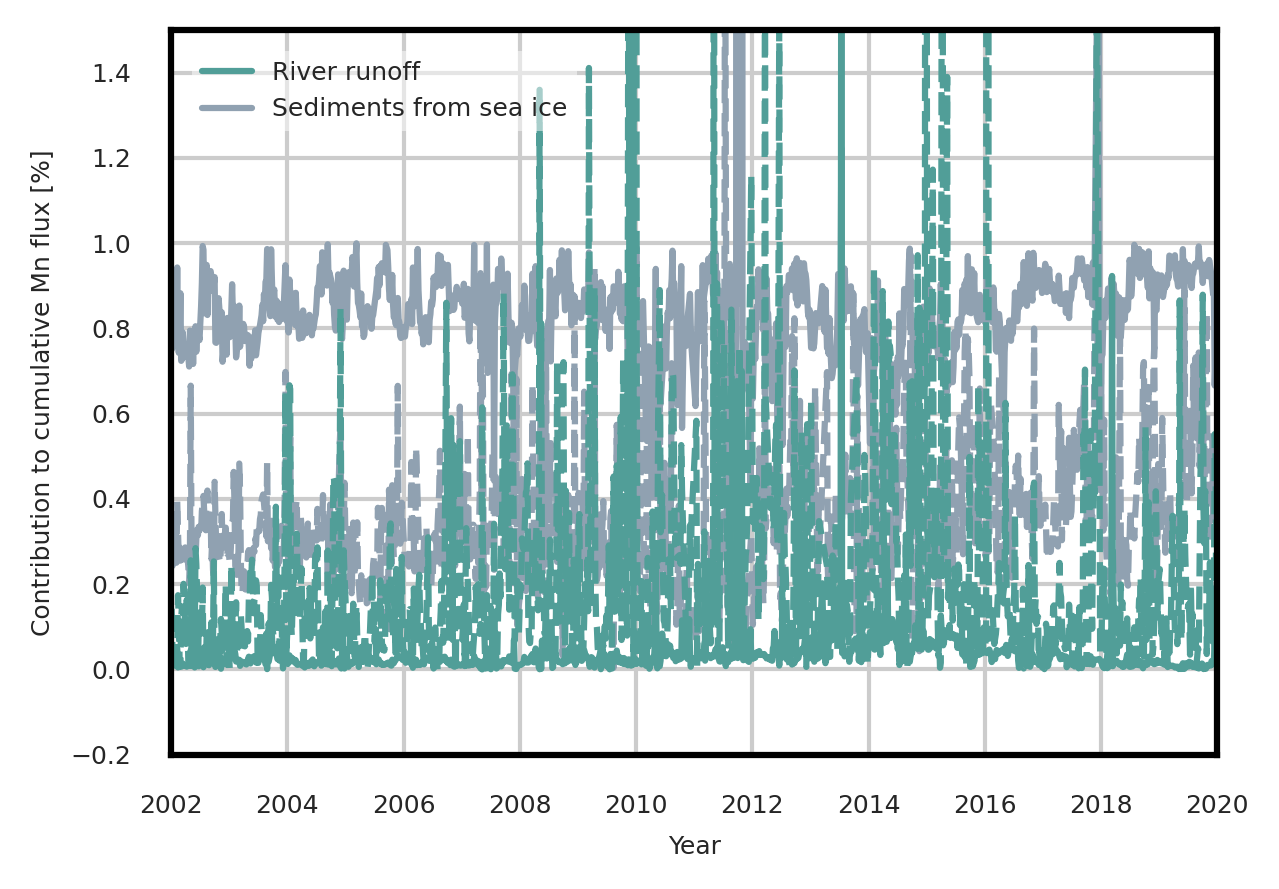

In [248]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, nosed_in_contr,   linewidth=1.5, color=dirty)
    sns.lineplot(dates,      nosed_out_contr,  linewidth=1.5, color=dirty)
    sns.lineplot(dates,      riv_in_contr,     linewidth=1.5, color=rivers)
    sns.lineplot(dates,      riv_out_contr,    linewidth=1.5, color=rivers)
    ax.lines[1].set_linestyle('--')
    ax.lines[3].set_linestyle('--')
    
    sns.lineplot(dates[0], [0], linewidth=1.5, color=rivers, label='River runoff')
    sns.lineplot(dates[0], [0], linewidth=1.5, color=dirty, label='Sediments from sea ice')
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Contribution to cumulative Mn flux [%]',fontsize=6)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.2,1.5))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black'); 
    
    leg = ax.legend(loc=(0.02, 0.86), frameon=True, framealpha=0.5, fontsize=6)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

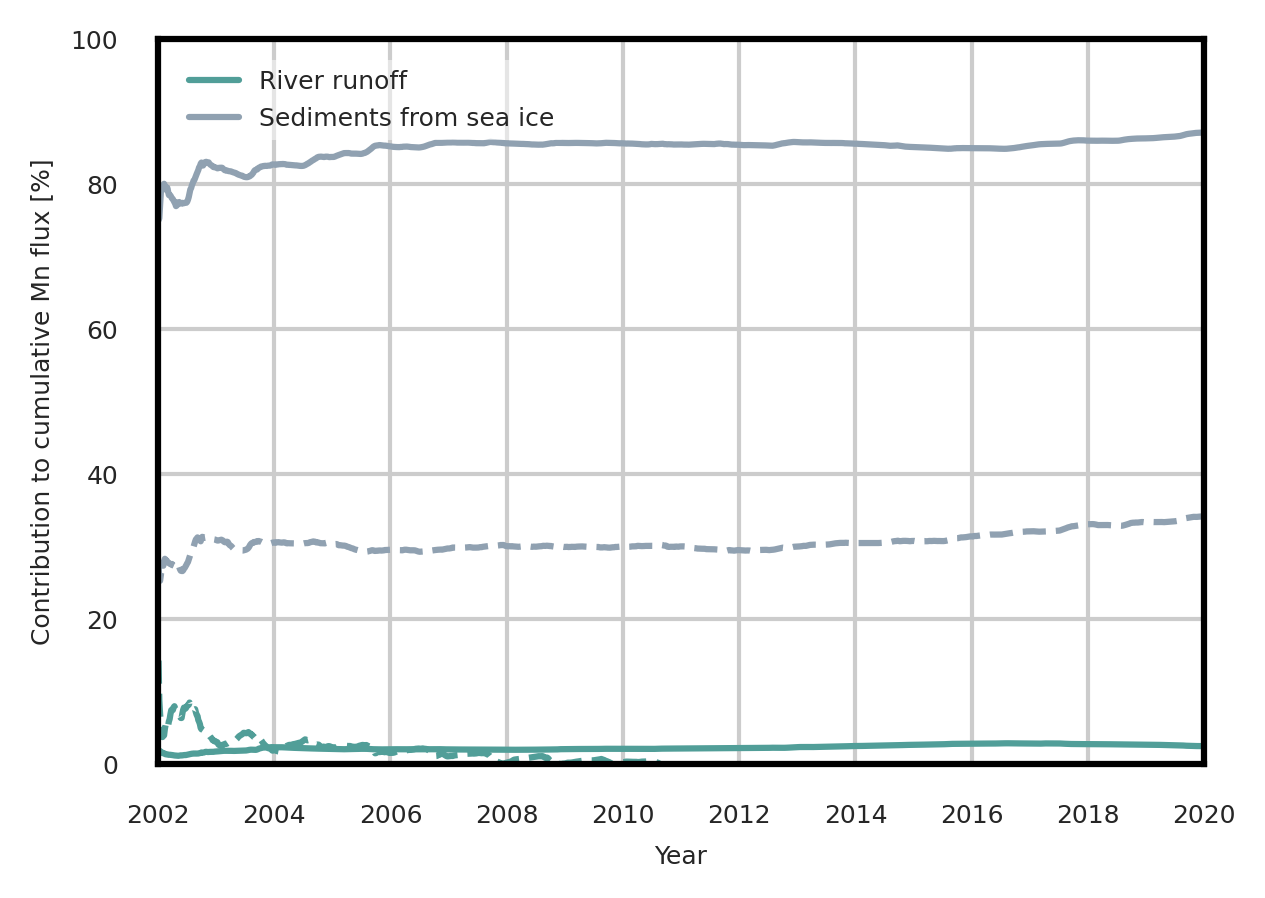

In [18]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, np.abs(1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin))*100, \
                 linewidth=1.5, color=dirty)
    sns.lineplot(dates,      np.abs(1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout))*100, \
                 linewidth=1.5, color=dirty)
    sns.lineplot(dates,      (np.divide(Parry_rivers_cumsumin, Parry_ref_cumsumin)-1)*100, \
                 linewidth=1.5, color=rivers)
    sns.lineplot(dates,      (np.divide(Parry_rivers_cumsumout, Parry_ref_cumsumout)-1)*100, \
                 linewidth=1.5, color=rivers)
    ax.lines[1].set_linestyle('--')
    ax.lines[3].set_linestyle('--')
    
    sns.lineplot(dates[0], [0], linewidth=1.5, color=rivers, label='River runoff')
    sns.lineplot(dates[0], [0], linewidth=1.5, color=dirty, label='Sediments from sea ice')
    
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Contribution to cumulative Mn flux [%]',fontsize=6)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 100))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black'); 
    
    leg = ax.legend(loc=(0.02, 0.86), frameon=True, framealpha=0.5, fontsize=6)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

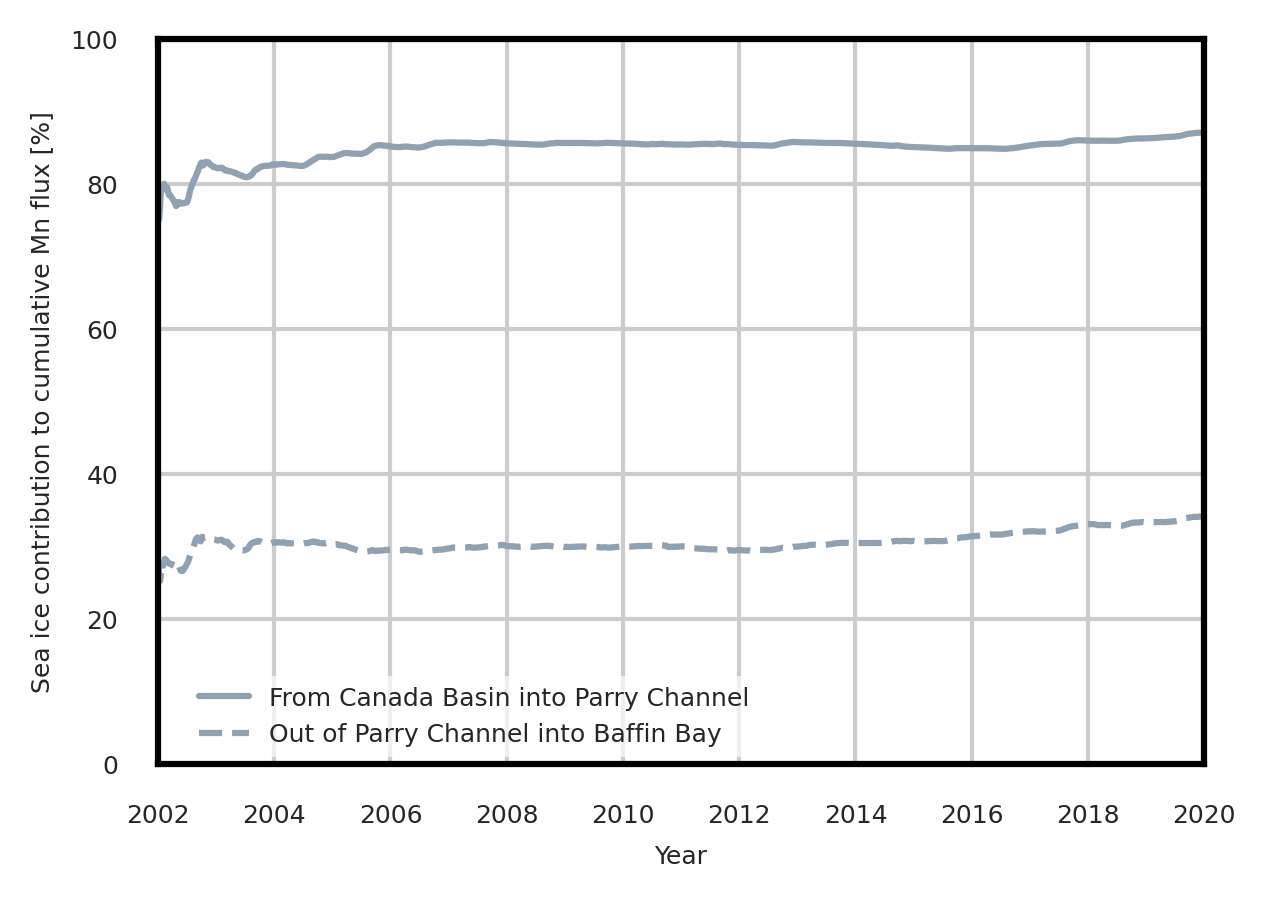

In [309]:
st  = sns.axes_style("whitegrid")

with st:
    fig = plt.figure(figsize=(4.5, 3.2), dpi=300)

    ax = sns.lineplot(dates, (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin))*100, \
                      linewidth=1.5, color=dirty, label=r'From Canada Basin into Parry Channel')
    sns.lineplot(dates, (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout))*100, \
                 linewidth=1.5, color=dirty, label=r'Out of Parry Channel into Baffin Bay')
    ax.lines[1].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Sea ice contribution to cumulative Mn flux [%]',fontsize=6)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 100))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.01), frameon=True, framealpha=0.7, fontsize=6)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.svg', format='svg', \
#                             bbox_inches='tight', dpi=300)

What about if instead of providing time series, we calculate the cumulative proportion contribution:

In [272]:
print('Into Parry Channel: ')
print(f'Clean-ref:  {-100*(np.nansum(Parry_nosed_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print('Out of Parry Channel: ')
print(f'Clean-ref:  {-100*(np.nansum(Parry_nosed_out)-np.nansum(Parry_ref_out))/np.nansum(Parry_ref_out):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_out)-np.nansum(Parry_ref_out))/np.nansum(Parry_ref_out):.2f}')

Into Parry Channel: 
Clean-ref:  87.06
Rivers-ref: 2.43
Out of Parry Channel: 
Clean-ref:  34.13
Rivers-ref: -0.62


In [ ]:
print('Into Parry Channel: ')
print(f'Clean-ref:  {-100*(np.nansum(Parry_nosed_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print('Out of Parry Channel: ')
print(f'Clean-ref:  {-100*(np.v(Parry_nosed_out)-np.v(Parry_ref_out))/np.v(Parry_ref_out):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_out)-np.nansum(Parry_ref_out))/np.nansum(Parry_ref_out):.2f}')

Into Parry Channel: 
Clean-ref:  87.06
Rivers-ref: 2.43
Out of Parry Channel: 
Clean-ref:  34.13
Rivers-ref: -0.62


### Plot the boundaries:

In [296]:
xmin=imin+1; ymin=jmin+1
l1i = 2013-xmin; l1j = np.arange(300-ymin,392-ymin)
l2i = 1935-xmin; l2j = np.arange(450-ymin,530-ymin)
l3i = np.arange(1850-xmin,1885-xmin); l3j = 555-ymin
l4i = np.arange(1753-xmin,1837-xmin); l4j = 568-ymin
l5i = np.arange(1720-xmin,1790-xmin); l5j = 605-ymin
l6i = 1730-xmin; l6j = np.arange(660-ymin,690-ymin)

t1i = np.arange(1635-xmin,1653-xmin); t1j = 760-ymin

r1i = 1520-xmin; r1j = np.arange(505-ymin,673-ymin)
r2i = 1520-xmin; r2j = np.arange(385-ymin,405-ymin)

N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin #Nares Strait
P1i = 1585-xmin; P1j = np.arange(485-ymin,538-ymin)  #Parry channel

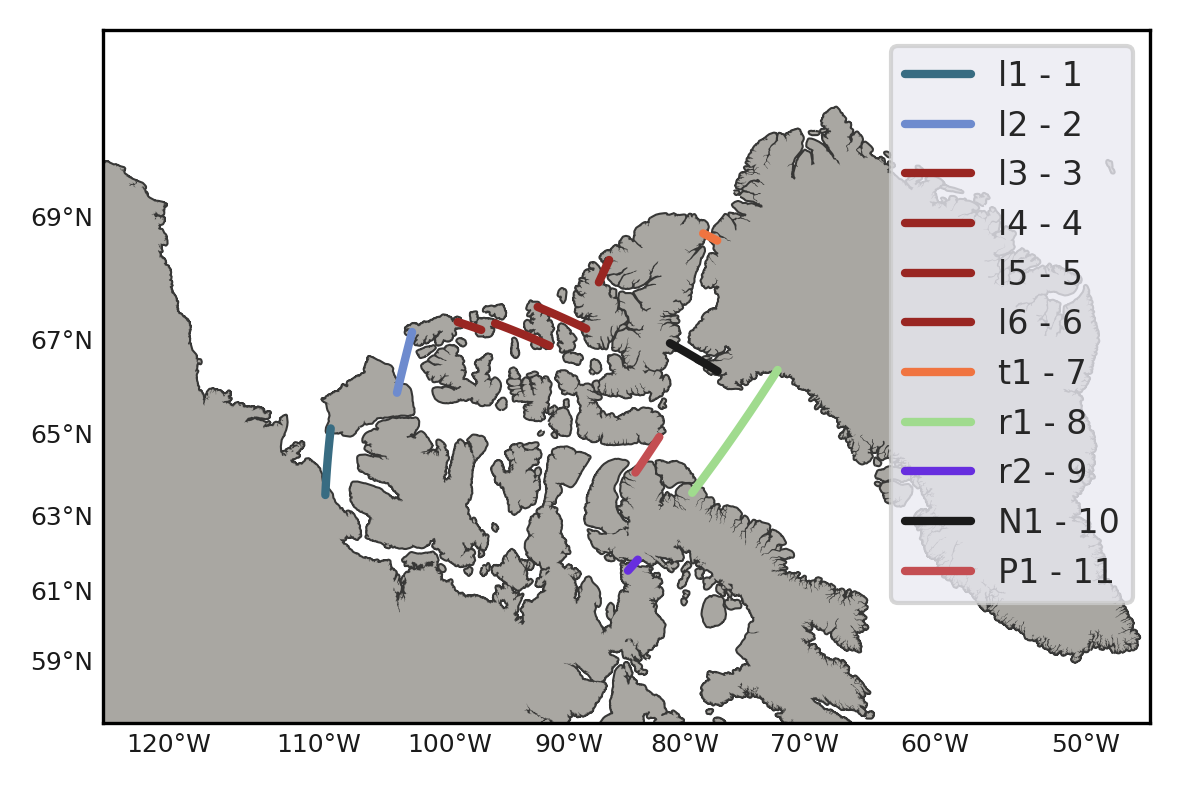

In [297]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

bdy_colours = ['#386c82','#6e8bce','#992622','#f07440','#a0db8e','#672edf']

x_model, y_model = proj1(lons[imin:imax,jmin:jmax], lats[imin:imax,jmin:jmax])
proj1.plot(x_model[l1i, l1j[0]:l1j[-1]], y_model[l1i, l1j[0]:l1j[-1]],'-', \
           c=bdy_colours[0], linewidth=2,zorder=4, label='l1 - 1') 
proj1.plot(x_model[l2i, l2j[0]:l2j[-1]], y_model[l2i, l2j[0]:l2j[-1]],'-', \
           c=bdy_colours[1], linewidth=2,zorder=4, label='l2 - 2') 
proj1.plot(x_model[l3i[0]:l3i[-1], l3j], y_model[l3i[0]:l3i[-1], l3j],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l3 - 3') 
proj1.plot(x_model[l4i[0]:l4i[-1], l4j], y_model[l4i[0]:l4i[-1], l4j],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l4 - 4')
proj1.plot(x_model[l5i[0]:l5i[-1], l5j], y_model[l5i[0]:l5i[-1], l5j],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l5 - 5')
proj1.plot(x_model[l6i, l6j[0]:l6j[-1]], y_model[l6i, l6j[0]:l6j[-1]],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l6 - 6')
proj1.plot(x_model[t1i[0]:t1i[-1], t1j], y_model[t1i[0]:t1i[-1], t1j],'-', \
           c=bdy_colours[3], linewidth=2,zorder=4, label='t1 - 7') 
proj1.plot(x_model[r1i, r1j[0]:r1j[-1]], y_model[r1i, r1j[0]:r1j[-1]],'-', \
           c=bdy_colours[4], linewidth=2,zorder=4, label='r1 - 8') 
proj1.plot(x_model[r2i, r2j[0]:r2j[-1]], y_model[r2i, r2j[0]:r2j[-1]],'-', \
           c=bdy_colours[5], linewidth=2,zorder=4, label='r2 - 9')  

proj1.plot(x_model[N1i[0]:N1i[-1], N1j], y_model[N1i[0]:N1i[-1], N1j],'-', \
           c='k', linewidth=2, zorder=4, label='N1 - 10') 
proj1.plot(x_model[P1i, P1j[0]:P1j[-1]], y_model[P1i, P1j[0]:P1j[-1]],'-', \
           c='r', linewidth=2, zorder=4, label='P1 - 11') 

ax1.legend(fontsize=8)

# Check volume conservation and volume fluxes relative to other studies:

In [15]:
volume_in_CAA   = np.empty([])
volume_Nares    = np.empty([])
volume_McClure  = np.empty([])
volume_Amundsen = np.empty([])
for year in years:
    ts_V1, ts_V2, ts_V3, ts_V4, ts_V5, ts_V6, \
        ts_V7, ts_V8, ts_V9, ts_V10, ts_V11 = check_volume_conservation(year)
    
    volume_in_CAA =  np.append(volume_in_CAA, \
                 -1*np.sum(ts_V1,axis=(1,2)) + \
                 -1*np.sum(ts_V2,axis=(1,2)) + \
                 -1*np.sum(ts_V3,axis=(1,2)) + \
                 -1*np.sum(ts_V4,axis=(1,2)) + \
                 -1*np.sum(ts_V5,axis=(1,2)) + \
                 -1*np.sum(ts_V6,axis=(1,2)) + \
                 -1*np.sum(ts_V7,axis=(1,2)) + \
                 np.sum(ts_V8,axis=(1,2)) + \
                 np.sum(ts_V9,axis=(1,2)))
    
    volume_Nares    = np.append(volume_Nares,    np.sum(ts_V7,axis=(1,2)))
    volume_McClure  = np.append(volume_McClure,  np.sum(ts_V2,axis=(1,2)))
    volume_Amundsen = np.append(volume_Amundsen, np.sum(ts_V1,axis=(1,2)))

In [16]:
print(f'Mean volume flux across boundary over 2003-2016: ')
print(f'Nares Strait:    {np.nanmean(volume_Nares*1e-6):.2f} Sv') 
print(f'McClure Strait:  {np.nanmean(volume_McClure*1e-6):.2f} Sv') 
print(f'Amundson Gulf:   {np.mean(volume_Amundsen*1e-6):.2f} Sv') 

Mean volume flux across boundary over 2003-2016: 
Nares Strait:    -0.91 Sv
McClure Strait:  -0.42 Sv
Amundson Gulf:   -0.05 Sv


These numbers are very similar to Grivault et al. (2018) who has similar boundaries and estimates volume flux in ANHA12.
The time series of fluxes in Nares Strait below also compares well with those in the above study.

Text(0.5, 1.0, 'Nares Strait')

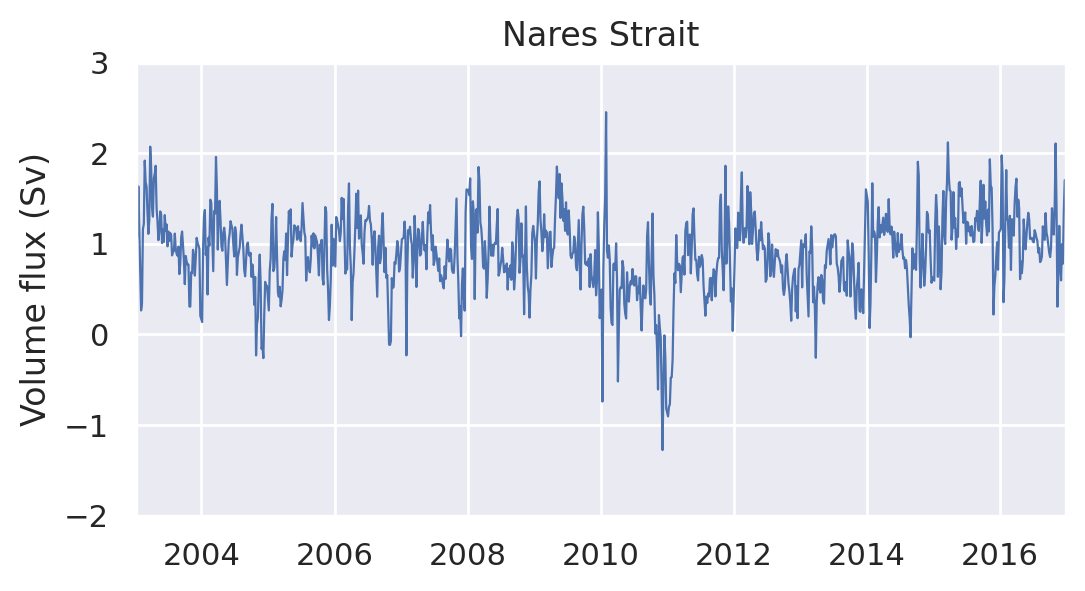

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
ax.plot(dates, -1*volume_Nares[0:-1]*1e-6, linewidth=0.8)
ax.set_xlim(dates[0], dates[-1])
ax.set_ylim([-2, 3])
ax.set_ylabel('Volume flux (Sv)')
ax.set_title('Nares Strait')

Text(0.5, 1.0, 'CAA')

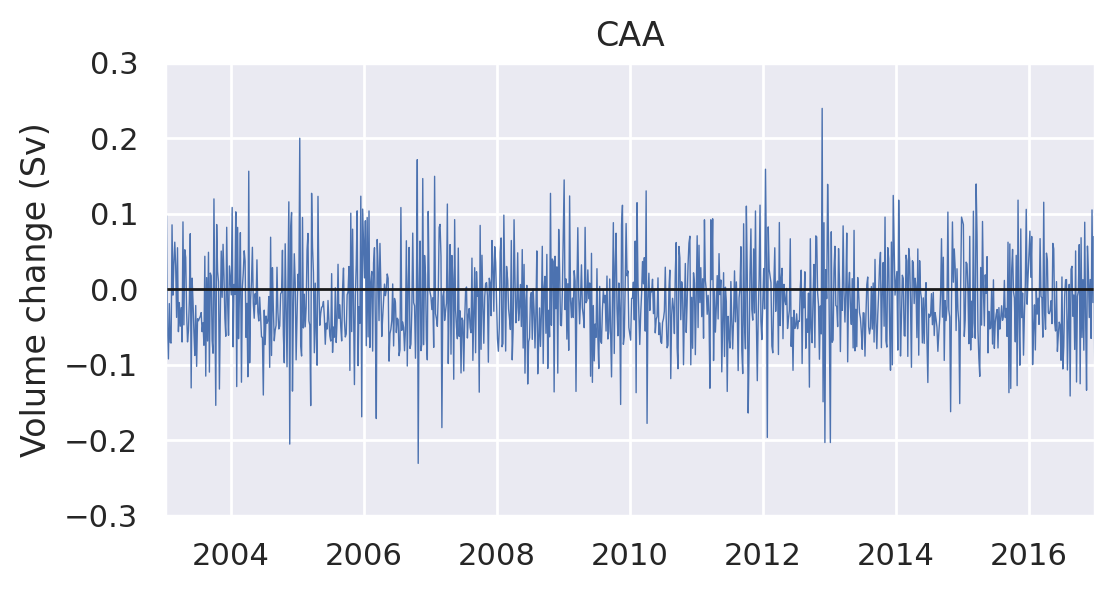

In [59]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
ax.plot(dates, volume_in_CAA[0:-1]*1e-6, linewidth=0.5)
ax.plot([dates[0], dates[-1]], [0, 0], '-k', linewidth=1.0)
ax.set_xlim(dates[0], dates[-1])
ax.set_ylim([-0.3, 0.3])
ax.set_ylabel('Volume change (Sv)')
ax.set_title('CAA')

Doesn't include river runoff and sea ice melt volume contributions.

In [17]:
# Area of grid cells:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e1t_base  = np.array(mesh.variables['e1t'])[0,imin-1:imax-1,jmin-1:jmax-1]
e2t_base  = np.array(mesh.variables['e2t'])[0,imin-1:imax-1,jmin-1:jmax-1]
e3t  = np.array(mesh.variables['e3t_0'])[0,:,:,:]

area = e1t_base*e2t_base

In [18]:
# Find indices to separate out Canada Basin:

x_ind = np.arange(1560, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700 -40

CB_indx = []; CB_indy = [];
for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)
    
# Separate Canada Basin and the CAA:
mask_ini_CAA = np.ones((isize,jsize))
for i, j in zip(CB_indx, CB_indy):
    try:
        mask_ini_CAA[int(i-imin),int(j-jmin)] = 0
    except:
        pass

mask_ini_CAA[0:r1i-3,:] = 0

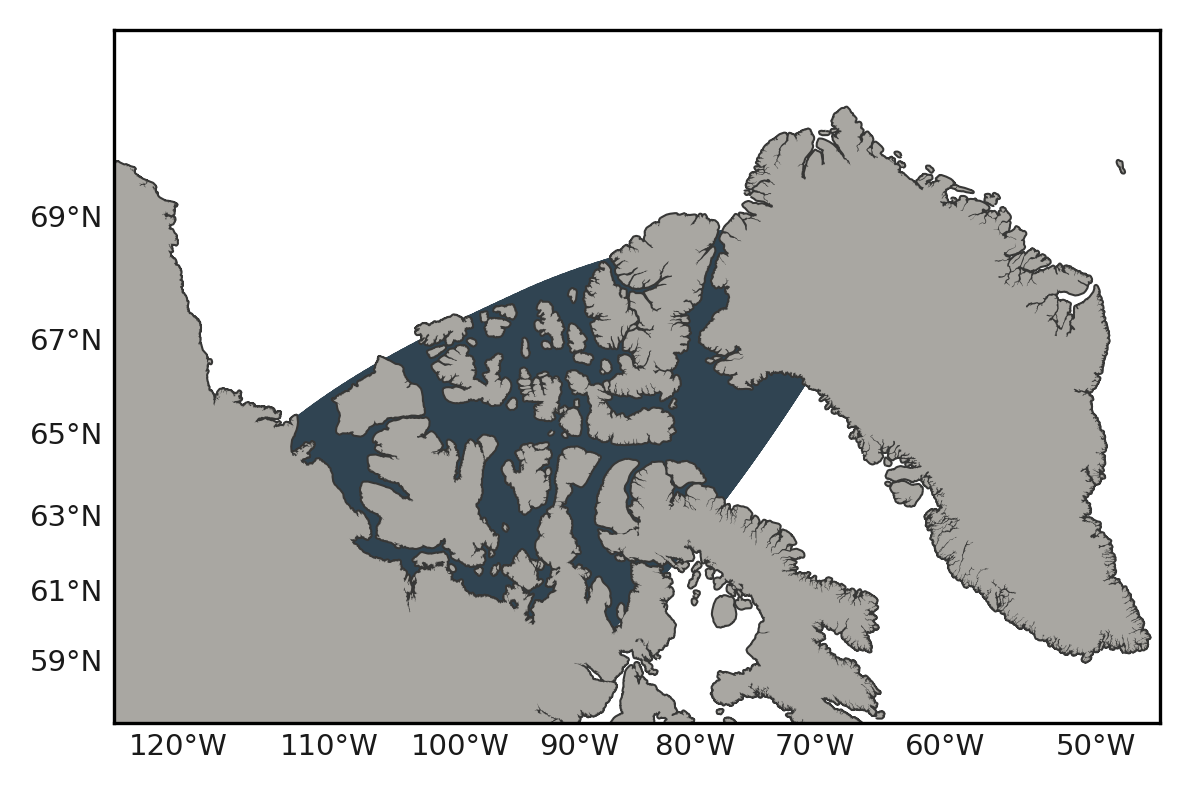

In [185]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(lons[imin:imax,jmin:jmax], lats[imin:imax,jmin:jmax]) 

# Draw domain boundaries:
proj1.plot(np.ma.masked_where(mask_ini_CAA==0  , x_sub), np.ma.masked_where(mask_ini_CAA==0  , y_sub),\
           '-', color='#304452', linewidth=10, zorder=1);

In [19]:
# Estimate contribution from river runoff:
rnf_2003    = nc.Dataset('/ocean/brogalla/GEOTRACES/data/runoff/'+\
                         'ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y2003.nc')
runoff      = np.array(rnf_2003.variables['runoff'])[:,imin-1:imax-1,jmin-1:jmax-1] # kg/s/m2

runoff_sub  = np.copy(runoff) 
mrunoff_sub = runoff_sub*mask_ini_CAA*area*1e-3 # units of runoff are kg / m2 / s --> kg / s --> m3 / s
number_days = [monthrange(2003,month)[1] for month in range(1,13)] # number of days in each month

In [24]:
# volume = melt rate (m/s) * grid cell area within CAA * time
iceprod = np.zeros(lons.shape)
for month in range(1,13):
    file     = nc.Dataset(f'/data/brogalla/ANHA12/icemod_ave/ANHA12-EXH006_icemod_y2003m{month:02}.nc')
    numdays  = monthrange(2003, month)[1]
#     ice_melt = np.array(file.variables['iiceprod'][0,:,:])
#     ice_melt[ice_melt > 0] = 0
    ice_vol  = np.array(file.variables['iiceprod'][0,:,:])
    iceprod  = iceprod + ice_vol*numdays*3600*24/180 # units of m/kt --> m/month
#     iceprod  = iceprod + ice_melt*numdays*3600*24/180 # units of m/kt --> m/month
    # summed over months so m/year
    
iceprod_sub = iceprod[imin-1:imax-1,jmin-1:jmax-1]*mask_ini_CAA*area/(3600*24*365) # m3 / s

In [25]:
print(f'Volume change in CAA over year 2003: {np.nansum(volume_in_CAA[0:72]*5*3600*24)*1e-6/(3600*24*365):.2f} Sv')
print(f'Unaccounted for volume additions: ')
print(f'- River runoff: {np.sum(np.sum(mrunoff_sub, axis=(1,2))*3600*24*number_days)*1e-6/(3600*24*365):.2f} Sv')
print(f'- Sea ice melt: {-1*np.sum(iceprod_sub, axis=(0,1))*1e-6:.2f} Sv')

Volume change in CAA over year 2003: -0.02 Sv
Unaccounted for volume additions: 
- River runoff: 0.01 Sv
- Sea ice melt: -0.02 Sv
